In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# Non Negative Matrix Factorization (NMF)

## Outline

- General presentation
    - Problem definition
    - Usage
    - Applications
- Algorithm
    - Manual implementation
    - Scikit-learn implementation
- Examples
    - Recommender system
    - Image understanding
    - Text mining

## What is Non-negative Matrix Factorization?

### Problem definition

- __Inputs__: 
    - A data matrix $X$ ($n \times p$), with $n$ data points and a feature space in $p$ dimensions, containing only __non negative__ ($\geq 0$) values.
    - An positive integer $r$, smaller than $n$ and $p$.
- __Objective__: Finding two matrices $W$ ($n \times r$) and $H$ ($r \times p$), containing only non negative values, such that:
$$X \approx WH$$

### Usage
- As $r << min(n, p)$, the dimension is drastically reduced and we get a new feature space representing the initial data.
- Encourages sparsity.
- Once the factorization has been built, it is easy to apply standard learning algorithms on $W$ and $H$ to build classifications (e.g., K-means, Agglomerative) or new representations (e.g., PCA).

### Applications

Can you find examples of problems where all data are non-negative?

### Applications

- __Text mining__: 
    - The original data are the number of occurences of some words in a text.
    - NMF allows to automatically discover topics of the texts.
- __Computer vision__:
    - Original data are RGB images (integer coefficients between 0 and 255).
    - NMF allows to automatically discover basic components of an image.
- __Recommender systems__:
    - Original data are ratings of products (e.g., movies).
    - NMF allows to predict what next product a customer is going to like.
- etc.

## NMF Algorithm

### Formulation of the NMF problem

We want to minimize the _distance_ between $X$ and $WH$.

$$\text{Minimize}_{W, H} \;\; D(X, WH)$$

$$\text{subject to} \;\; w_{ij} \geq 0, \forall i \in \{1, ..., n\}, \forall j \in \{1, ..., r\}$$
$$\;\;\;\;\;\;\;\;\;\;\;\;\;\; h_{ij} \geq 0, \forall i \in \{1, ..., r\}, \forall j \in \{1, ..., p\}$$

The choice of the divergence function $D(., .)$ defines the $W$ and $H$ matrices obtained.

### Popular divergences for NMF

$D(M, \hat{M})$ is a _matrix distance_:

$$ D(M, \hat{M}) = \sum_{i=1}^{n} \sum_{j=1}^{p} d(m_{ij}, \hat{m}_{ij}),$$

and $d(x, y)$ is defined for all $x, y \geq 0$ as a scalar distance. Popular choices for $d(., .)$ are:
- __Euclidean distance__: $d(x, y) = (x - y)^2$. In this case, $D(., .)$ is the __Frobenius norm__.
- __Kullback-Leibler divergence__: $d(x, y) = x\log\frac{x}{y} - x + y$.
- __Itakura-Saito divergence__: $d(x, y) = \frac{x}{y} - \log \frac{x}{y} - 1$.

### Solving NMF using the multiplicative update rule

Solving the optimization problem presented above is difficult (NP-hard).\
To address this issue, many heuristics have been develop to find approximate solutions (local optima).

#### Multiplicative update rule
- Initialize $W$ and $H$ as non negative matrices: $W^0$ and $H^0$.
- Repeat until convergence:
    - Update $H$: 
    $$H^{n+1}_{ij} = H^n_{ij} \frac{((W^n)^TX)_{ij}}{((W^n)^TW^nH^n)_{ij}}$$
    - Update $W$: 
    $$W^{n+1}_{ij} = W^n_{ij} \frac{(X(H^{n+1})^T)_{ij}}{(W^nH^{n+1}(H^{n+1})^T)_{ij}}$$

#### Exercise: Compute manually the first $H$ update for the following matrix $X$

$$X = \begin{bmatrix}2 & 1 & 3\\
4 & 2 & 1\\
1 & 3 & 3 \end{bmatrix}$$

- The desired latent dimension is $2$.
- $W^0$ and $H^0$ are initialized full of ones.

#### Exercise: Write two functions for the two update steps.

- The first function __update_H__ can be tested using the matrices from the previous exercise.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

X = np.array([[2,1,3],
              [4,2,1],
              [1,3,3]])

W = np.array([[1,1],
              [1,1],
              [1,1]])

H = np.array([[1,1,1], 
              [1,1,1]])

In [4]:
def update_H(W, H, X):
    WX = W.T.dot(X)
    WWH = W.T.dot(W.dot(H))

    return H * WX / WWH
 
new_H = update_H(W, H, X)
print(new_H)

[[1.16666667 1.         1.16666667]
 [1.16666667 1.         1.16666667]]


In [5]:
def update_W(W, H, X):
    XH = X.dot(H.T)
    WHH = W.dot(H.dot(H.T))

    return W * XH / WHH

new_W = update_W(W, new_H, X)
print(new_W)

[[0.91791045 0.91791045]
 [1.05223881 1.05223881]
 [1.02985075 1.02985075]]


#### Exercise: Compute the NMF of the matrix $X$ defined above.

- $W$ and $H$ can be initialized with small random values.
- The iterations can stop when the Frobenius norm (_np.linalg.norm_) between two updates of both $H$ and $W$ is less than $10^{-10}$
- Compare the original matrix $X$ with the approximation $W^TH$ obtained.

In [6]:
W = np.random.normal(0, 0.01, size=(3, 2))
H = np.random.normal(0, 0.01, size=(2, 3))

oldW, oldH = W + 1, H + 1
while (np.linalg.norm(H-oldH) > 1e-10) and (np.linalg.norm(W-oldW) > 1e-10):
    oldH, oldW = np.copy(H), np.copy(W)
    H = update_H(W, H, X)
    W = update_W(W, H, X)
    
print("Original data")
print(X)
print("\nReconstructed data")
print(W.dot(H))
print("\nSquared reconstruction error")
print(np.linalg.norm(W.dot(H) - X)**2)

Original data
[[2 1 3]
 [4 2 1]
 [1 3 3]]

Reconstructed data
[[1.75703093 1.95239992 2.40412313]
 [4.06198444 1.75703088 1.15201564]
 [1.15201558 2.40412318 3.37281525]]

Squared reconstruction error
1.9243227669664924


#### Exercise: Compute the NMF of $X$ using scikit-learn and compare the results.

- from sklearn.decomposition import NMF

In [7]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=2, init="random", solver="mu")
nmf.fit(X)
W = nmf.transform(X)
H = nmf.components_

print("Original data")
print(X)
print("\nReconstructed data")
print(W.dot(H))
print("\nSquared reconstruction error")
print(np.linalg.norm(W.dot(H) - X)**2)

Original data
[[2 1 3]
 [4 2 1]
 [1 3 3]]

Reconstructed data
[[1.75626547 1.95230938 2.40490883]
 [4.06174261 1.75870975 1.15082786]
 [1.15437603 2.40294054 3.37256237]]

Squared reconstruction error
1.9243300401041417


#### Initialization

Several approaches can be implemented regarding the initialization of $W$ and $H$.

- Several random initializations
- Non-negative double singular value decomposition (NNSVD)
- A classification (k-means) of either rows or columns
- etc.

## NMF examples

### Example 1: Text mining

In [8]:
from sklearn.datasets import fetch_20newsgroups

data, _ = fetch_20newsgroups(
    shuffle=True,
    random_state=1,
    remove=("headers", "footers", "quotes"),
    return_X_y=True)

In [9]:
example_text_id = np.random.randint(len(data))

print("Number of texts in the dataset:", len(data))
print("Example text: \n\n", data[example_text_id])

Number of texts in the dataset: 11314
Example text: 

 Dear Netters:

A new religious newsgroup "soc.religion.islam.ahmadiyya" was pro-
posed  on  Oct  16,  1992. The discussion about this new proposed
newsgroup went on in various related groups.  The  proposal,  was
supposed to enter a vote during the last week of November 92. Due
to a false Call For Votes, by some opponent, the voting had to be
canceled.  I  quote  here  a  statement  from  the  moderator  of
new.announce.newgroups:


"The current Call For Votes (CFV) for an Ahmadiyya newsgroup
 is being canceled. A new call for votes will be issued within
 a few weeks, possibly with a new impartial vote  taker.  Discus-
 sion on the proposal is still open until the new vote is called..."
                                -- by Lawrence, Nov 20, 1992.


A lot of confusion arose among the netter as  to  whom  to  vote.
Therefore  it was decided to give a cool down period, so that all
confusions are over. It has been over 4 months  of  t

In [10]:
# Convert text to TfIdf

from sklearn.feature_extraction.text import TfidfVectorizer

n_samples = 2000
n_features = 1000

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=n_features, stop_words="english")
tfidf_data = tfidf_vectorizer.fit_transform(data)

feature_names = tfidf_vectorizer.get_feature_names_out()

In [11]:
print("Number of texts:", tfidf_data.shape[0])
print("Number of TfIdf features:", tfidf_data.shape[1])

print("\nMost important words for example text:")
tfidf_data_print = tfidf_data[example_text_id].tocoo()
for i in range(len(tfidf_data_print.col)):
    print("%10s\t%s" % (feature_names[tfidf_data_print.col[i]], tfidf_data_print.data[i]))

Number of texts: 11314
Number of TfIdf features: 1000

Most important words for example text:
      wide	0.04360836781667399
     false	0.0449801605908548
   history	0.03821646060404205
   brought	0.04360836781667399
   society	0.04157661060539068
       age	0.08800413758121113
   million	0.042199437729217235
    events	0.043232744864564784
    claims	0.042061925630050366
      went	0.037937191947251224
  supposed	0.04140703402115034
 religious	0.46070309020909544
     earth	0.040236214786635915
   decided	0.08306777164529813
     moral	0.04459954418280615
 situation	0.039439895951097814
     weeks	0.0402726592892233
 knowledge	0.04087899421374904
discussion	0.15596234980812182
  possibly	0.04179364660191356
     bring	0.04140703402115034
christianity	0.04447650761910228
     basis	0.04224579353199041
    second	0.03211638672002188
  religion	0.23928257570853922
    common	0.07549445013656841
    christ	0.04128211896419914
 important	0.07215720101559514
   purpose	0.040346038949724786


In [12]:
nmf = NMF(n_components=10, beta_loss="kullback-leibler", init="nndsvda", 
          solver="mu", max_iter=1000, alpha=0.1, l1_ratio=0.5)
nmf.fit(tfidf_data)

W = nmf.transform(tfidf_data)
H = nmf.components_

/home/joris/miniconda3/envs/clustering_lectures/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


In [13]:
def plot_topics(H):
    n_top_words = 10
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for i in range(H.shape[0]):
        topic = H[i, :]
        top_features = topic.argsort()[: -n_top_words - 1 : -1]
        top_features_names = [feature_names[j] for j in top_features]
        top_features_scores = [topic[j] for j in top_features]

        ax = axes[i]
        ax.barh(top_features_names, top_features_scores, height=0.7)
        ax.set_title(f"Topic {i+1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

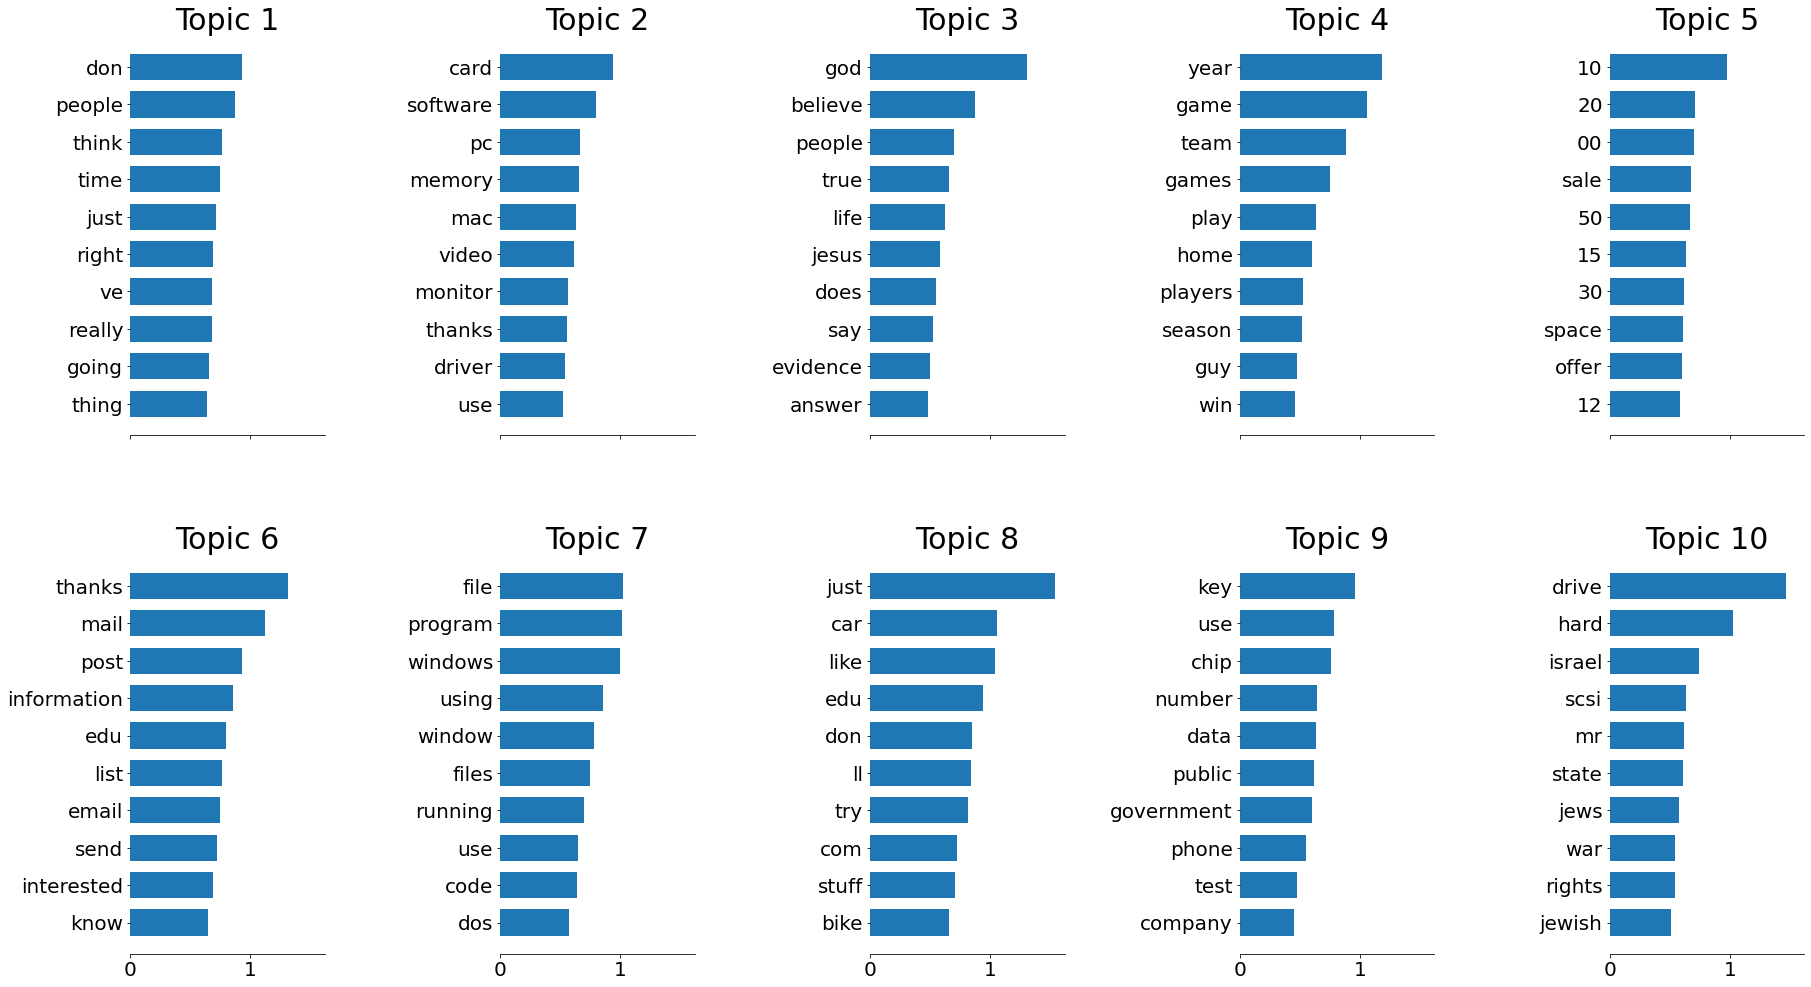

In [14]:
plot_topics(H)

### Example 2: Image understanding

In [15]:
from sklearn.datasets import fetch_olivetti_faces

image_shape = (64, 64)

faces, _ = fetch_olivetti_faces(return_X_y=True, shuffle=True)
n_samples, n_features = faces.shape

print("The dataset is composed of %i face images" % n_samples)
print("Images contain %i features (64x64 images)" % n_features)

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /home/joris/scikit_learn_data
The dataset is composed of 400 face images
Images contain 4096 features (64x64 images)


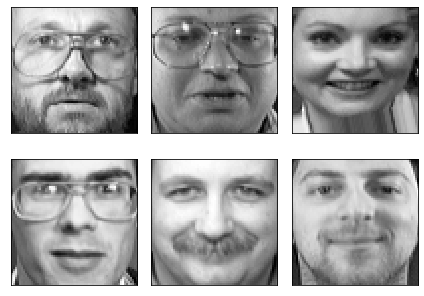

In [16]:
# Visualize first images

n_row, n_col = 2, 3
plt.figure(figsize=(2.0 * n_col, 2.26 * n_row))
for i in range(len(faces[:n_row*n_col])):
    plt.subplot(n_row, n_col, i + 1)
    plt.imshow(faces[i].reshape(image_shape), cmap=plt.cm.gray, interpolation="nearest")
    plt.xticks(())
    plt.yticks(())
plt.tight_layout()
plt.show()

In [17]:
nmf = NMF(n_components=6, init="nndsvda", tol=5e-3)
nmf.fit(faces)

W = nmf.transform(faces)
H = nmf.components_

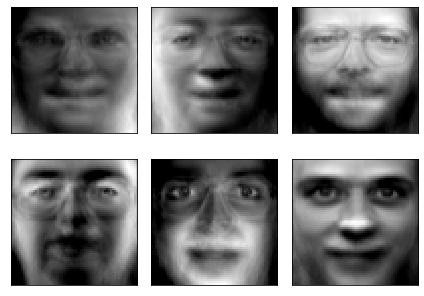

In [18]:
# Visualize image components

plt.figure(figsize=(2.0 * n_col, 2.26 * n_row))
for i in range(len(faces[:n_row*n_col])):
    plt.subplot(n_row, n_col, i + 1)
    plt.imshow(H[i].reshape(image_shape), cmap=plt.cm.gray, interpolation="nearest")
    plt.xticks(())
    plt.yticks(())
plt.tight_layout()
plt.show()

#### Exercise: 
- Display the reconstructed images corresponding to the first six images
- Are the images realistic?
- Try again with more latent variables. (20?)

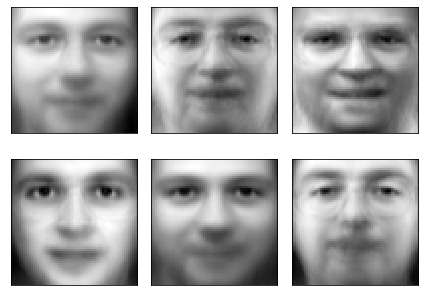

In [19]:
# Reconstructed images

reconstructed_images = W.dot(H)
plt.figure(figsize=(2.0 * n_col, 2.26 * n_row))
for i in range(len(reconstructed_images[:n_row*n_col])):
    plt.subplot(n_row, n_col, i + 1)
    plt.imshow(reconstructed_images[i].reshape(image_shape), cmap=plt.cm.gray, interpolation="nearest")
    plt.xticks(())
    plt.yticks(())
plt.tight_layout()
plt.show()

In [20]:
nmf = NMF(n_components=20, init="nndsvda", tol=5e-3)
nmf.fit(faces)

W = nmf.transform(faces)
H = nmf.components_

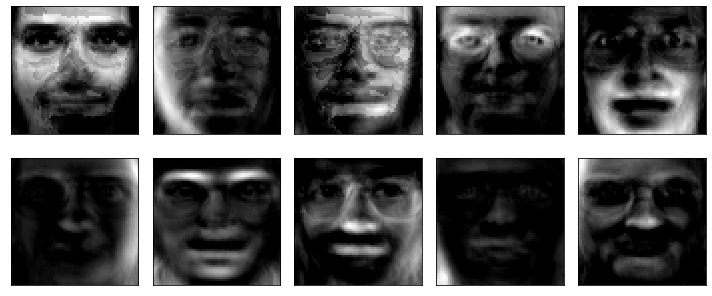

In [21]:
plt.figure(figsize=(2.0 * 5, 2.26 * 2))
for i in range(len(faces[:10])):
    plt.subplot(2, 5, i + 1)
    plt.imshow(H[i].reshape(image_shape), cmap=plt.cm.gray, interpolation="nearest")
    plt.xticks(())
    plt.yticks(())
plt.tight_layout()
plt.show()

Reconstructed images


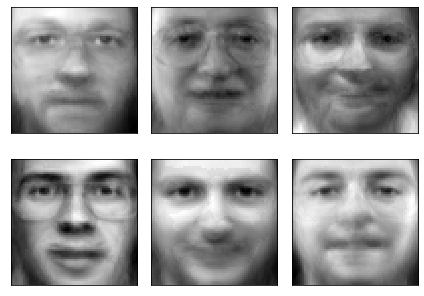

Original images


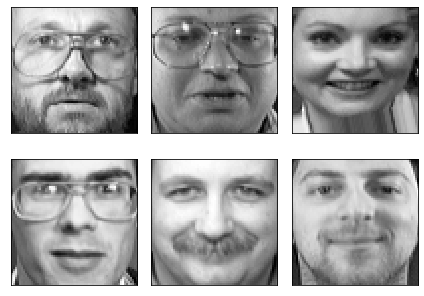

In [22]:
print("Reconstructed images")

reconstructed_images = W.dot(H)
plt.figure(figsize=(2.0 * n_col, 2.26 * n_row))
for i in range(len(reconstructed_images[:n_row*n_col])):
    plt.subplot(n_row, n_col, i + 1)
    plt.imshow(reconstructed_images[i].reshape(image_shape), cmap=plt.cm.gray, interpolation="nearest")
    plt.xticks(())
    plt.yticks(())
plt.tight_layout()
plt.show()

print("Original images")

plt.figure(figsize=(2.0 * n_col, 2.26 * n_row))
for i in range(len(faces[:n_row*n_col])):
    plt.subplot(n_row, n_col, i + 1)
    plt.imshow(faces[i].reshape(image_shape), cmap=plt.cm.gray, interpolation="nearest")
    plt.xticks(())
    plt.yticks(())
plt.tight_layout()
plt.show()

#### Exercise:

- Select an image at random in the dataset
- Display the top 3 characteristic images used to encode it?
- What is the percentage of explained reconstruction corresponding to these 3 characteristic images?

Original image


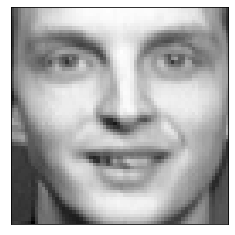

Reconstructed image


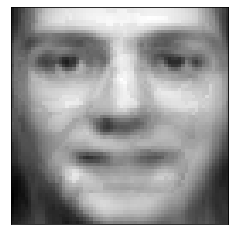

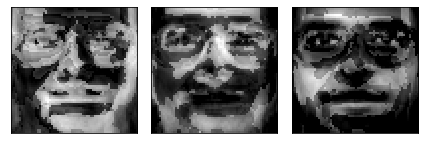

Explained reconstruction:  73.66325184829002 %


In [25]:
index = np.random.randint(faces.shape[0])
print("Original image")
plt.imshow(faces[index].reshape(image_shape), cmap=plt.cm.gray, interpolation="nearest")
plt.xticks(())
plt.yticks(())
plt.show()

print("Reconstructed image")
plt.imshow(W.dot(H)[index].reshape(image_shape), cmap=plt.cm.gray, interpolation="nearest")
plt.xticks(())
plt.yticks(())
plt.show()

sorted_scores = np.argsort(-W[index, :], )
plt.figure(figsize=(2.0 * 3, 2.26 * 1))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(H[sorted_scores[i]].reshape(image_shape), cmap=plt.cm.gray, interpolation="nearest")
    plt.xticks(())
    plt.yticks(())
plt.tight_layout()
plt.show()

print("Explained reconstruction: ", 100 * np.sum(W[index, sorted_scores[:3]]) / np.sum(W[index, :]), "%")